In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH  = '../resources/model_results/svm_linear_grid.npy'
MODEL_PATH  = '../resources/best_models/svm_linear.npy'
TRAIN_MODEL = False

# Linear Support Vector Machine Model

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

Linear support vector machine try to find an optimal hyperplane with margins to separate two classes. In a nutshell, SVC try to find the best hyperplane that classify correctly the observations and in the same time try to maximize their distance (the margins) from this plane. Small margins allow to have models with low bias (few misclassifications) but because there are also few support vectors, with high variance. Reciproquely, bigger margins will allow more misclassifications (higher bias) but with margins defined by more support vectors, so less flexible, so a model with less variance. The C parameter in `LinearSVC` allows to tune this bias/variance trade-off: small C value lead to bigger margins (high bias/low variance, potential underfitting), high C values lead to smaller margins (low bias/high variance, potential overfitting). For our model, we will use the `LinearSVC` algorithm that is computationally more efficient than `SVC` with a linear kernel.

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components
* Penalty parameter C of the error term
* Loss function
 
Note that because the imbalance of our target variable, we apply weights inversely proportional to class frequencies: `class_weight='balanced'`.

In [4]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]
svc__C = np.logspace(-4, 3, 100)
svc__loss = ['hinge', 'squared_hinge']


# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('svc', LinearSVC(penalty='l2', class_weight='balanced', max_iter=1000, tol=1e-4, random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'svc__C': svc__C,
        'svc__loss': svc__loss
    })
    
    # Scorers
    average_precision_scorer = make_scorer(average_precision_score, 
                                           greater_is_better=True, 
                                           needs_proba=False,
                                           needs_threshold=True)
    
    roc_auc_scorer = make_scorer(roc_auc_score, 
                                 greater_is_better=True, 
                                 needs_threshold=True)
    
    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': roc_auc_scorer,
            'average_precision': average_precision_scorer
        },
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [5]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('C', r['param_svc__C']),
    ('loss', r['param_svc__loss']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 1000


,n_components,C,loss,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,0.0001,hinge,0.652388,0.650487,0.001901,0.003040,0.013400
1,9,0.0001,squared_hinge,0.671861,0.669212,0.002648,0.003269,0.013503
2,9,0.000117681,hinge,0.651681,0.650278,0.001402,0.003561,0.012405
3,9,0.000117681,squared_hinge,0.672151,0.670948,0.001204,0.003169,0.014547
4,9,0.000138489,hinge,0.650288,0.650700,0.000412,0.004300,0.013258


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

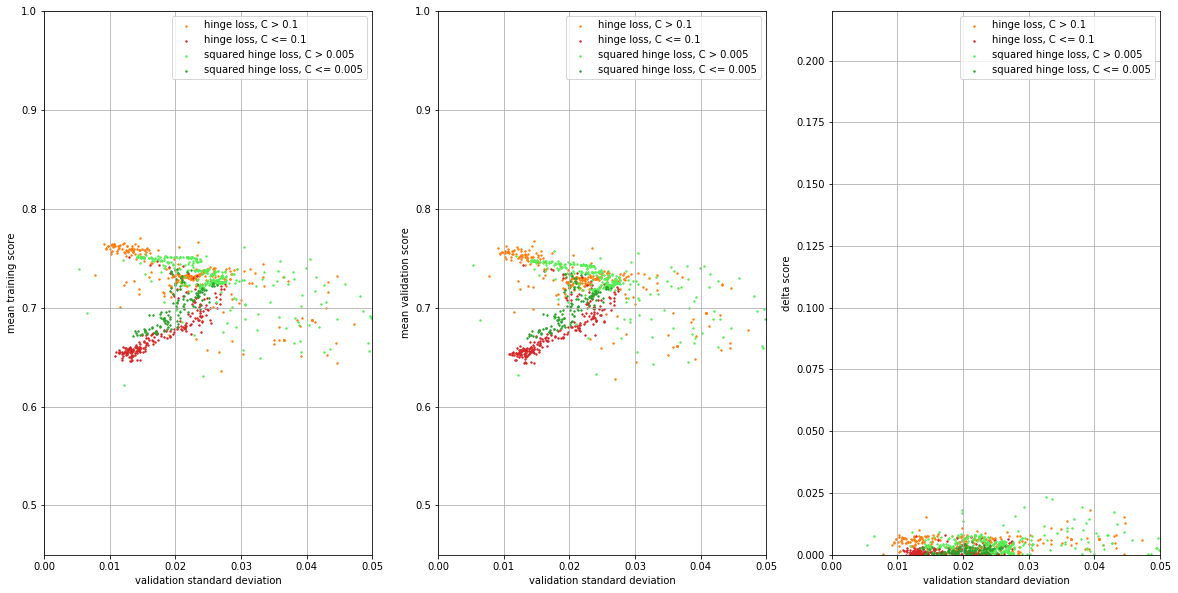

In [6]:
# Selection filters
filter_loss = (df.loss == 'hinge')
filter_C = (df.C > 0.1)
filter_C2 = (df.C > 0.005)


# Plot vars
legend_loc = ['upper right', 'upper right', 'upper right']
ylabel = ['mean training score', 'mean validation score', 'delta score']
ylims = [(0.45, 1), (0.45, 1), (0, 0.22)]

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[filter_loss & filter_C], df.loc[filter_loss & filter_C, var], color='C1', label='hinge loss, C > 0.1', s=2)
    ax[i].scatter(df.std_valid_score[filter_loss & ~filter_C], df.loc[filter_loss & ~filter_C, var], color='C3', label='hinge loss, C <= 0.1', s=2)
    ax[i].scatter(df.std_valid_score[~filter_loss & filter_C2], df.loc[~filter_loss & filter_C2, var], color='#55EE55', label='squared hinge loss, C > 0.005', s=2)
    ax[i].scatter(df.std_valid_score[~filter_loss & ~filter_C2], df.loc[~filter_loss & ~filter_C2, var], color='C2', label='squared hinge loss, C <= 0.005', s=2)
 
    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, 0.05), ylim=ylims[i])
    ax[i].legend(loc=legend_loc[i])
    i += 1

plt.show()

As expected, when C is too low, the bias increase and the precision score drop. It appears that models with C > 0.1 and hinge loss function are better.

Given the results, our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1%
* mean validation precision >= 75%

In [7]:
# Model selection according to some wished criteria
f_std_valid = (df.std_valid_score <= 0.01)
f_valid_score = (df.mean_valid_score >= 0.75)

filter =  f_std_valid & f_valid_score
best_models = df[filter].sort_values(by='std_valid_score', ascending=True)
best_models

,n_components,C,loss,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
936,21,6.42807,hinge,0.764038,0.760226,0.003812,0.004607,0.009107
950,21,20.0923,hinge,0.759632,0.754919,0.004713,0.004900,0.009423
938,21,7.56463,hinge,0.759991,0.754823,0.005168,0.004283,0.009426
940,21,8.90215,hinge,0.762894,0.756530,0.006364,0.004594,0.009709
914,21,1.07227,hinge,0.762509,0.756192,0.006318,0.004905,0.009710


The models with the best validation standard deviation has also the best mean validation precision score. So, we will select this first model as our best linear SVM model. Note that all the models are models for which the PCA number of components is set to None (=21). It can be probably explained by the fact that more dimensions give more flexibility to find an optimal hyperplane in the N dimensional feature space.

### Best model evaluation on the test set

We must now to train these model on the full training set and evaluate it on the test set :

In [8]:
# Best model hyperparameters
pca__n_components = best_models.n_components.values[0]
svc__C =  best_models.C.values[0]
svc__loss = best_models.loss.values[0]

if TRAIN_MODEL:
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca__n_components, random_state=0)),
        ('svc', LinearSVC(C=svc__C,
                          loss=svc__loss,
                          class_weight='balanced', 
                          penalty='l2', 
                          max_iter=1000, 
                          tol=1e-4, 
                          random_state=0))
    ])
    pipe.fit(X_train, y_train)
    
    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)
else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)

In [9]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('Linear SVM Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('Linear SVM Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
Linear SVM Precision (training set):  0.76
Linear SVM Precision (test set) :  0.796


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	439 (TN)	 27 (FN)
Predicted P	 88 (FP)	344 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.796
Recall    :  0.927
Accuracy  :  0.872
F1 Score  :  0.857


Given the non linear nature of our problem, it's not surprising that this model performs less well than the others models regarding the precision metric. It appears that linear models are good to identify most of the exoplanets, represented here by a recall of 93%. The test precision score of 80% is better than predicted by cross-validation but probably by chance.

We expect the SVM model with an RBF kernel to be much better than this model and probably better also than the random forest and knn models...